NOTAS:
he exact 112 stock_ids in the training set will appear in both the public leader board and the private leader board test sets
public test set is hidden and private test set will be real market data collected in the three-month evaluation period after competition ends.

loss: RMSELoss vs MSE?  
https://www.kaggle.com/gunesevitan/optiver-realized-volatility-prediction-eda  
RMSPE is very similar to RMSE. The only difference between them is, the error is divided by the actual value. Predictions closer to actual values yield errors closer to 0, so division by actual values is sensitive to larger errors. In addition to that, errors are squared before they are averaged, which makes this metric even more sensitive to larger errors. This means larger errors are not tolerable in this domain.  
One pitfall of RMSPE is it can raise ZeroDivisionError if a single data point in actual values is equal to 0. Even though, there isn't any 0 target values in training set, this can be easily solved by adding a small constant to actual values. A small constant epsilon wouldn't contribute to overall rmspe and it prevents ZeroDivisionError.

###################################################################################

sumar y mean en las visualizaciones

--- feature engineering (domingo) ---
algo estadístico, Z scores, statistica learning, time series en youtube
necesito calcular el resigo de liquidity drought en base a los volumenes y el spread de alguna forma (order imbalance) - conv 2d  
volumne unbanace, ...
primera derivada, ...

--- model CNN / MLP (lunes y martes) ---
fit on vol delta
arquitectura en general / segundo modelo MLP en secuencia?
exponential avg pooling
2d conv?, wavelet?
auoregressive conv network? inductive kernels?
loss weights
segmentation + transformer?
(NO) nn.GRU nn.RNN nn.LSTM?

--- augmentation y generalization (miercoles y jueves) ---
!!! tengo que incrementar la capacidad del modelo antes de probar generalization: dropout, data augmentation, noise
entrenar con baskets de stocks - esta seria una forma de gerneralizar??
https://docs.scipy.org/doc/scipy/reference/reference/ndimage.html#module-scipy.ndimage
filtros, autoencoder

--- visualizar (viernes) ---
analizar peores predicciones
analizar casos donde no había volatilidad en los primeros 10 minutos, pero la hay en los 10 posteriores

--- competition (fin de semana) ---
releer los FAQS, etc para no dejarme ningún detalle / kaggle notebooks
quitar asserts
cross-validation
reproductibilidad
optim?

In [19]:
import pandas as pd
import numpy as np

from scipy.stats import beta
from sklearn.preprocessing import StandardScaler

from matplotlib.pyplot import figure
from matplotlib import pyplot as plt
import seaborn as sns

from data import OptiverDataModule

import skimage.measure

import torch
import torch.nn as nn


pd.set_option('display.max_rows', 500)
np.set_printoptions(threshold=1000, linewidth=150, precision=3, edgeitems=20, suppress=1)

%matplotlib inline

np.random.seed(0)
np.set_printoptions(threshold=2000, linewidth=140, precision=4, edgeitems=10, suppress=1)

In [20]:
data = OptiverDataModule(scale=True)

reading tensors file...
computing stock stats...


  0%|          | 0/9 [00:00<?, ?it/s]

processing series...


100%|██████████| 9/9 [00:42<00:00,  4.76s/it]


min: [-0.0078, 0.0, 0.0, 0.0, 0.0, 0.0, -0.0012, -0.0023, -0.0031, -0.0003, 0.0, -2.728, -6.2157, -0.6194, -1.4035, -0.0075, 0.0, -2.7987, 0.0, -5.1392, -0.5, -280481.0, -27756.998]
max: [0.0096, 0.0232, 0.018, 0.0164, 0.0075, 0.0053, 0.0011, 0.0019, 0.0025, 0.0002, 0.0012, 2.8314, 6.2068, 0.6733, 1.3314, 0.0069, 0.0525, 2.9797, 1.0, 5.0618, 0.5, 147403.0, 28616.998]
computing targets...
computing series stats...
non-series stats
[-0.05  0.01 -0.26]

stat_func: mean
corrs: [-0.01 -0.24 -0.25 -0.25 -0.25 -0.23  0.12  0.1   0.08  0.15 -0.24 -0.04 -0.03  0.02  0.02 -0.01 -0.25 -0.   -0.    0.01  0.01  0.    0.
 -0.01 -0.22 -0.22 -0.22 -0.23 -0.21  0.07  0.05  0.04  0.08 -0.22 -0.03 -0.01  0.01  0.01 -0.01 -0.22 -0.   -0.    0.01  0.01  0.   -0.
 -0.01 -0.19 -0.2  -0.21 -0.21 -0.19  0.04  0.03  0.03  0.04 -0.2  -0.02 -0.01  0.    0.   -0.01 -0.2   0.   -0.    0.01  0.01  0.    0.
 -0.    0.13  0.14  0.14  0.14  0.12 -0.   -0.01 -0.   -0.01  0.12  0.03  0.02  0.   -0.   -0.    0.14 -0.   -0

In [21]:
data.targets = pd.DataFrame( data.targets[data.targets[:,-1].argsort()],
                        columns=['stock','window','series','fut_vol','past_vol','vol_delta','vol_increase',])
data.targets.stock = data.targets.stock.astype(int)
data.targets.window = data.targets.window.astype(int)
data.targets.series = data.targets.series.astype(int)

In [22]:
pd.set_option('display.max_rows', 50)
data.targets

,stock,window,series,fut_vol,past_vol,vol_delta,vol_increase
0,31,25504,179217,0.000139,0.003528,-0.003389,-0.960603
1,31,27174,179418,0.000123,0.002662,-0.002539,-0.953736
2,31,8534,177193,0.000105,0.001986,-0.001880,-0.946987
3,31,4142,176682,0.000137,0.002061,-0.001924,-0.933457
4,31,2479,176487,0.000109,0.001375,-0.001266,-0.920727
...,...,...,...,...,...,...,...
428927,111,24817,56572,0.019343,0.001248,0.018095,14.503821
428928,31,8840,177236,0.003263,0.000194,0.003068,15.780264
428929,31,8590,177200,0.003702,0.000210,0.003492,16.598482
428930,59,23823,278600,0.069165,0.002654,0.066511,25.064619


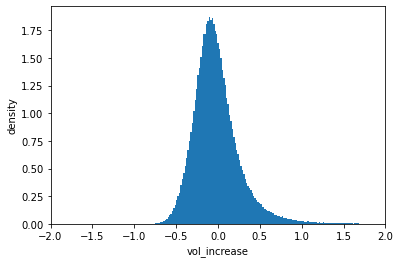

In [101]:
def plot_hist(x, xlim, title, bins=2000):

    plt.hist(x, density=True, bins=bins)
    plt.ylabel('density')
    plt.xlabel(title)
    plt.xlim(*xlim)

plot_hist(data.targets.vol_increase, (-2,2), 'vol_increase')

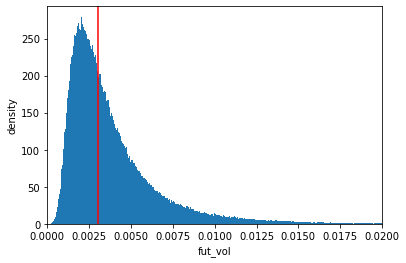

In [105]:
plot_hist(data.targets.fut_vol, (0,0.02), 'fut_vol')
plt.axvline(x=np.median(data.targets.fut_vol),color='red')

In [35]:
tar = data.targets[(data.targets.vol_increase > -0.5) & (data.targets.vol_increase < 0.5)]
tar

,stock,window,series,fut_vol,past_vol,vol_delta,vol_increase
6291,108,25197,41294,0.001608,0.003216,-0.001608,-0.499997
6292,116,14751,74544,0.004862,0.009724,-0.004862,-0.499995
6293,119,9279,81537,0.003108,0.006216,-0.003108,-0.499991
6294,67,17578,308505,0.005425,0.010849,-0.005425,-0.499987
6295,18,30412,129962,0.017542,0.035080,-0.017538,-0.499943
...,...,...,...,...,...,...,...
408336,116,8623,73797,0.006135,0.004090,0.002045,0.499968
408337,5,26578,248270,0.004425,0.002950,0.001475,0.499988
408338,5,13729,246749,0.004951,0.003301,0.001650,0.499989
408339,80,5704,356864,0.011529,0.007686,0.003843,0.499995



---------------------------- ALL ----------------------------


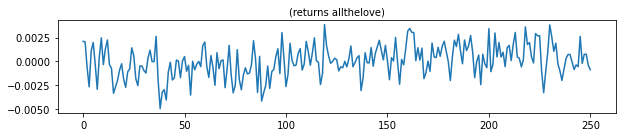

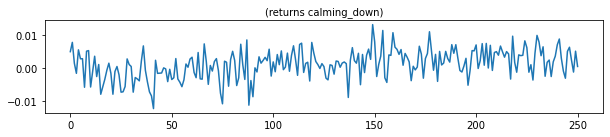

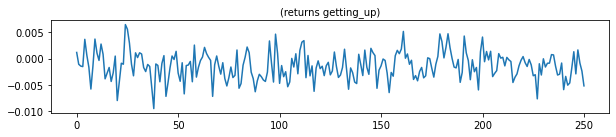

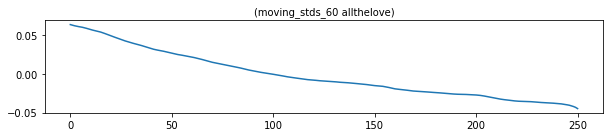

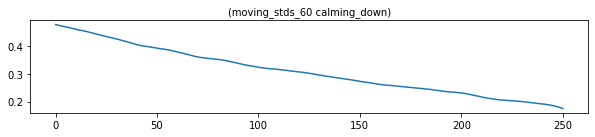

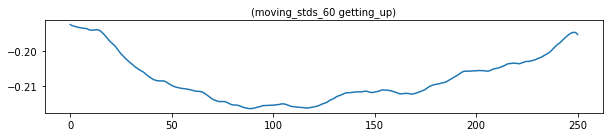

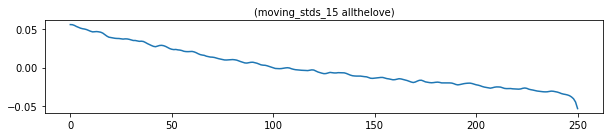

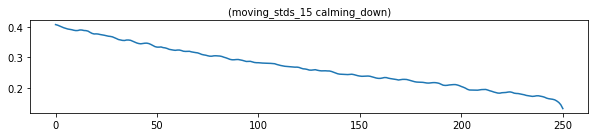

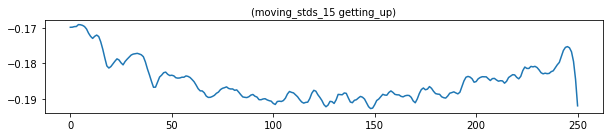


---------------------------- VOLATILE ----------------------------


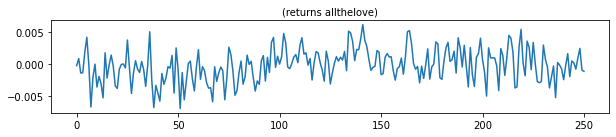

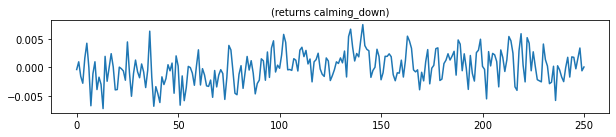

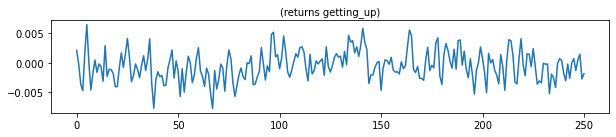

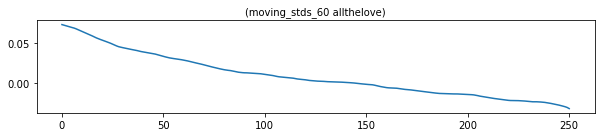

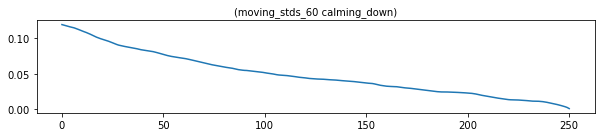

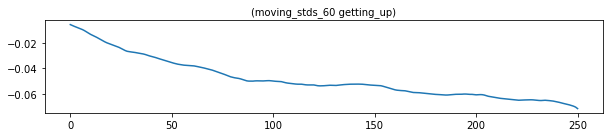

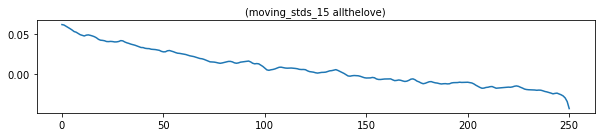

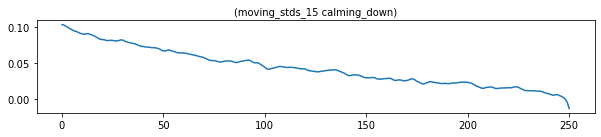

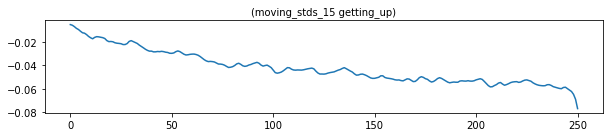


---------------------------- NON-VOLATILE ----------------------------


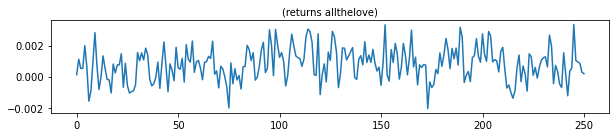

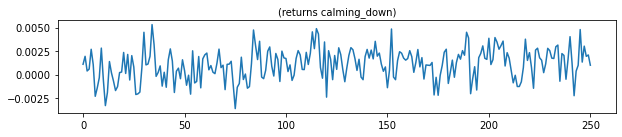

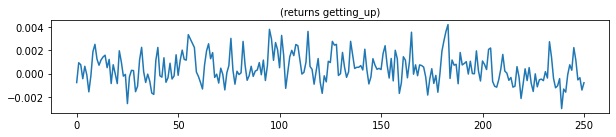

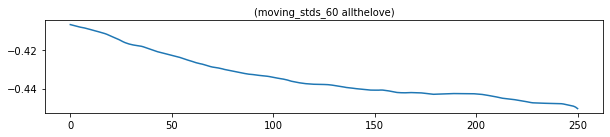

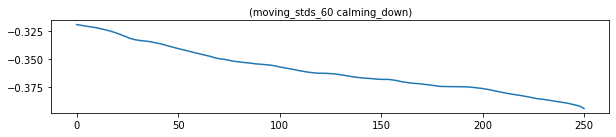

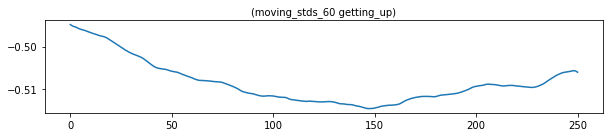

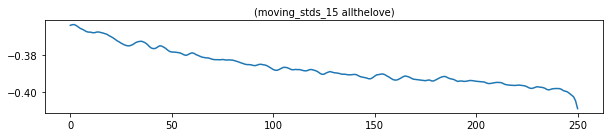

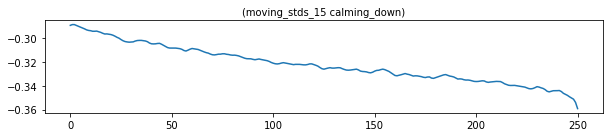

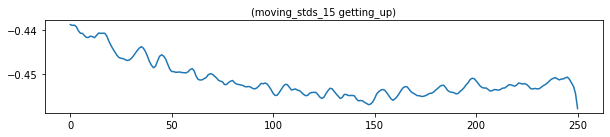

In [114]:
def loles_leon(aggre, num=100000):

    allthelove   = np.mean(data.series[aggre.series],axis=0)
    calming_down = np.mean(data.series[aggre.iloc[:num].series],axis=0)
    getting_up   = np.mean(data.series[aggre.iloc[-num:].series],axis=0)

    def shoeme(s, t, l=0, h=0.1):

        fig, ax = plt.subplots(1,1,figsize=(10,1.7))

        ax.set_title(t,fontsize=10)
        ax.plot(s)#, alpha=.8
        #ax.set_ylim(l, h) 

        plt.show()

    shoeme(allthelove[0], '(returns allthelove)')
    shoeme(calming_down[0], '(returns calming_down)')
    shoeme(getting_up[0], '(returns getting_up)')

    # shoeme(allthelove[1], '(moving_stds_60 allthelove)')
    # shoeme(calming_down[1], '(moving_stds_60 calming_down)')
    # shoeme(getting_up[1], '(moving_stds_60 getting_up)')

    # shoeme(allthelove[3], '(moving_stds_15 allthelove)')
    # shoeme(calming_down[3], '(moving_stds_15 calming_down)')
    # shoeme(getting_up[3], '(moving_stds_15 getting_up)')

    # shoeme(allthelove[4], '(moving_stds15_mean60 allthelove)')
    # shoeme(calming_down[4], '(moving_stds15_mean60 calming_down)')
    # shoeme(getting_up[4], '(moving_stds15_mean60 getting_up)')

print(); print('---------------------------- ALL ----------------------------')
loles_leon(tar)

print(); print('---------------------------- VOLATILE ----------------------------')
loles_leon(tar[(tar.fut_vol > 0.003) & (tar.fut_vol < 0.005)])

print(); print('---------------------------- NON-VOLATILE ----------------------------')
loles_leon(tar[(tar.fut_vol > 0.001) & (tar.fut_vol < 0.003)])

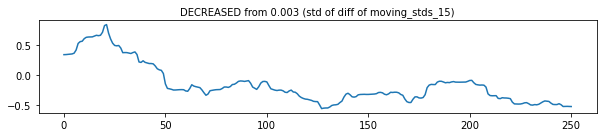

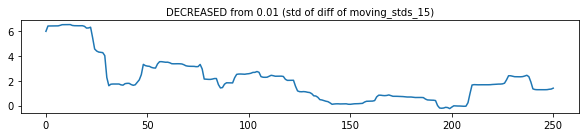

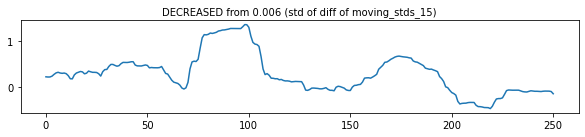

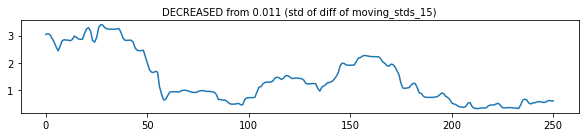

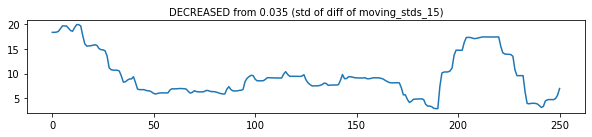

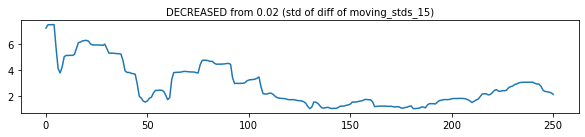

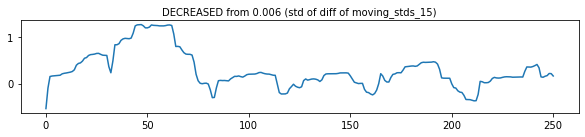

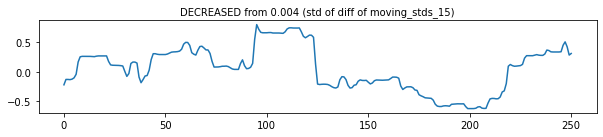

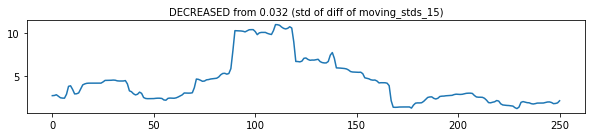

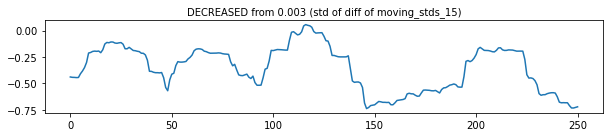




            -------------------------------- INCREASE -------------------------------- 


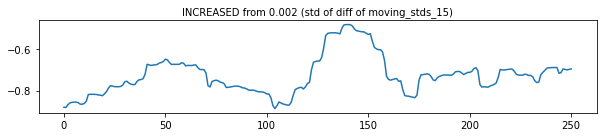

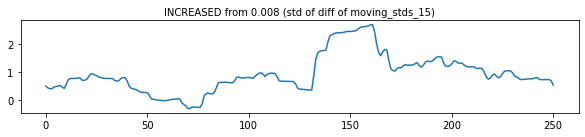

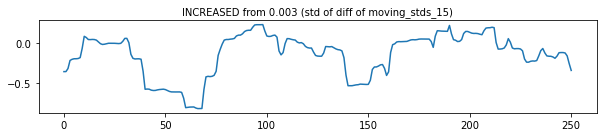

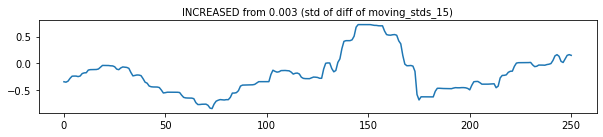

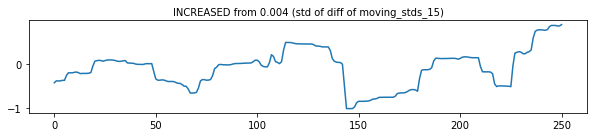

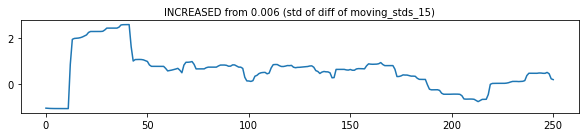

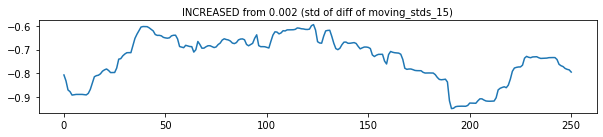

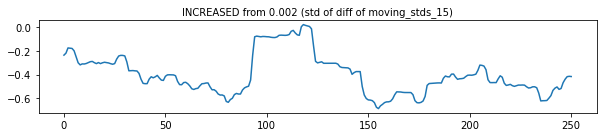

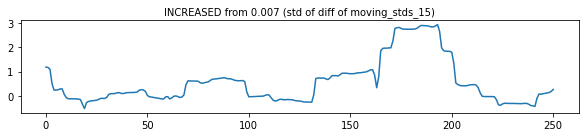

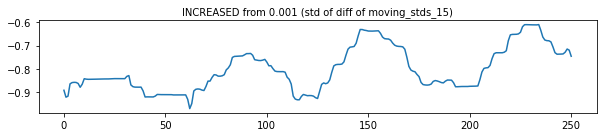

In [76]:
def showall(r,t):

    #shoeme(data.series[int(r.series),0], t+' (returns)')  # menos uniforme cuando vol aumenta
    
    #shoeme(data.series[int(r.series),1], 'moving_stds_60 '+t,0,15)   # definitivamente veo tendencia
    #shoeme(data.series[int(r.series),2], t+' (moving_stds_30)') # ESTOS NO RECOGEN LO QUE QUIERO
    #shoeme(data.series[int(r.series),3], t+' (moving_stds_15)') 

    # este esta bien, es como un suavizado sin tener que recurrir mucho al pasado
    #shoeme(data.series[int(r.series),4], t+' (moving_stds15_mean60)')

    # no lo entiendo
    # shoeme(data.series[int(r.series),5], t+' (moving_stds15_std60)')  

    #shoeme(data.series[int(r.series),6], t+' (diff of moving_stds_60)')
    #shoeme(data.series[int(r.series),7], t+' (diff of moving_stds_30)')
    #shoeme(data.series[int(r.series),8], t+' (diff of moving_stds_15)') 

    #shoeme(data.series[int(r.series),9], t+' (mean of diff of moving_stds_15)')
    #shoeme(data.series[int(r.series),10], t+' (std of diff of moving_stds_15)') 

count=10

for row in range(count):

    showall(tar.iloc[row], 'DECREASED from ' + str(np.round(tar.iloc[row].past_vol,3)))


print()
print()
print()
print('            -------------------------------- INCREASE -------------------------------- ')

for row in range(-1,-count-1,-1):

    showall(tar.iloc[row], 'INCREASED from ' + str(np.round(tar.iloc[row].past_vol,3)))

showall(tar.iloc[row], 'INCREASED from ' + str(np.round(tar.iloc[row].past_vol,3)))

    

In [43]:
for kk in range(5):
    print(tar.iloc[kk])

stock             108.000000
window          25197.000000
series          41294.000000
fut_vol             0.001608
past_vol            0.003216
vol_delta          -0.001608
vol_increase       -0.499997
Name: 6291, dtype: float64
stock             116.000000
window          14751.000000
series          74544.000000
fut_vol             0.004862
past_vol            0.009724
vol_delta          -0.004862
vol_increase       -0.499995
Name: 6292, dtype: float64
stock             119.000000
window           9279.000000
series          81537.000000
fut_vol             0.003108
past_vol            0.006216
vol_delta          -0.003108
vol_increase       -0.499991
Name: 6293, dtype: float64
stock               67.000000
window           17578.000000
series          308505.000000
fut_vol              0.005425
past_vol             0.010849
vol_delta           -0.005425
vol_increase        -0.499987
Name: 6294, dtype: float64
stock               18.000000
window           30412.000000
series       

In [ ]:
wap_means = np.std(data.WAP, axis=1)

In [ ]:
def plot_hist(x,bins=1000):

    plt.hist(x, density=True, bins=bins)
    plt.ylabel('Density')
    plt.xlabel('Price')
    #plt.xlim(0.98,1.02)
    plt.xlim(0,0.01)

plot_hist(wap_means)

In [ ]:
def plot_hist(x,bins=1000):

    plt.hist(x, density=True, bins=bins)
    plt.ylabel('Density')
    plt.xlabel('Realized Volatility')
    plt.xlim(0,0.02)

plot_hist(data.targets[:,2])

In [ ]:
#TODO: agrupar por stock y mostrar la distribución para los 10 más volátiles y para los 10 menos
target_means = pd.DataFrame(data.targets).groupby(0).agg({2:'mean'})
target_means = target_means.rename(columns={2: "mean"})

targets_values = pd.DataFrame(data.targets).groupby(0)[2].apply(list)
targets_values = targets_values.rename("values")

targets = pd.concat((target_means, targets_values), axis=1)

targets.sort_values('mean', ascending=True, inplace=True)

#targets

In [ ]:
plot_hist(targets.iloc[0,1], 200)
plot_hist(targets.iloc[-1,1], 200)

TODO: Plotear la diferencia entre la relaized volatility de ambas ventanas

The order book helps traders to make more informed trading decisions by showing order imbalances that may provide clues to a stock’s direction in the very short term. A huge imbalance of buy orders against sell orders may indicate a move higher in the stock due to buying pressure, or vice versa. Traders can also use the order book to help pinpoint a stock’s potential support and resistance levels. A cluster of large buy orders at a specific price may indicate a level of support, while an abundance of sell orders at or near one price may suggest an area of resistance. Realized volatilities increase when those moves in either directions become more frequent.https://www.kaggle.com/gunesevitan/optiver-realized-volatility-prediction-eda

In [ ]:
#data.t[105,2:3].T

In [ ]:
rv = data.stats[:,0]

In [ ]:
ind = np.argsort(rv)
ind, rv[ind[:3]], rv[ind[-3:]]

In [ ]:
ind[0], ind[-1]

In [ ]:
data.series.shape

In [ ]:
s = data.series

In [ ]:
data.series[1,0]

In [ ]:
def pp(t, kernel_size=30, stride=6):

    fig, (ax1,ax2,ax3) = plt.subplots(3,1,figsize=(20,4))

    ax1.set_title('WAP / deepWAP - 1',fontsize=14)
    ax1.plot(t[0], alpha=.8)

    v = nn.AvgPool1d(kernel_size=kernel_size, stride=stride)(torch.Tensor(t[0:1]).unsqueeze(0)).detach().numpy().squeeze()

    ax2.set_title('WAP / deepWAP - 1 (2)',fontsize=14)
    ax2.plot(v, alpha=.8)

    t2 = t[2:3]
    t3 = t[3:4]

    ts2 = nn.AvgPool1d(kernel_size=kernel_size, stride=stride)(torch.Tensor(t2).unsqueeze(0)).detach().numpy().squeeze()
    ts3 = nn.AvgPool1d(kernel_size=kernel_size, stride=stride)(torch.Tensor(t3).unsqueeze(0)).detach().numpy().squeeze()

    ax3.set_title('WAP / deepWAP - 1 (3)',fontsize=14)
    ax3.plot(ts2 / ts3 - 1, alpha=.8)

    plt.show()

s = data.series[ind[0]]
pp(s)
#pp(nn.AvgPool1d(kernel_size=30, stride=6)(torch.Tensor(s).unsqueeze(0)).detach().numpy().squeeze())

#pp(data.series[ind[-1]])

# for i in range(105,108):

#     pp(data.series[i])


In [ ]:
def pp(t,text):

    fig, ax1 = plt.subplots(1,1,figsize=(20,2))

    ax1.set_title(text,fontsize=14)
    ax1.plot(t, alpha=.8)

    plt.show()


for i in range(105,106):

    pp(nn.AvgPool1d(kernel_size=1, stride=6)(torch.Tensor(data.t[i,2:3]).unsqueeze(0)).detach().numpy().squeeze(), 'log returns')


In [ ]:
# for uu in np.argsort(data.stats)[100:110]:

#     ex = data.books[uu]
#     # ex = np.diff(ex[6]-ex[7]+ex[8]-ex[9], prepend=0)[1:]
#     # ex = np.expand_dims(ex, axis=0)

#     pp(nn.AvgPool1d(kernel_size=50, stride=6)(torch.Tensor(ex).unsqueeze(0)).detach().numpy().squeeze())


In [ ]:
# for uu in np.argsort(data.stats)[-200:-100]:

#     ex = data.books[uu]
#     # ex = np.diff(ex[6]-ex[7]+ex[8]-ex[9], prepend=0)[1:]
#     # ex = np.expand_dims(ex, axis=0)

#     pp(nn.AvgPool1d(kernel_size=50, stride=6)(torch.Tensor(ex).unsqueeze(0)).detach().numpy().squeeze())

In [ ]:
#diferencia entre ask volume y bid volume
#WAP entre bandas ask price y bid price